In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division, print_function
import codecs
import re
import json
import random
import math
import os
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt
import pylab
import pandas as pd
from scipy.stats import norm
import nltk

In [2]:
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [3]:
reuters = nltk.corpus.reuters
word_counts = np.array(sorted([float(len(reuters.words(id))) for id in reuters.fileids()], reverse=False))
mean_word_count = np.mean(word_counts)
std_word_count = np.std(word_counts)

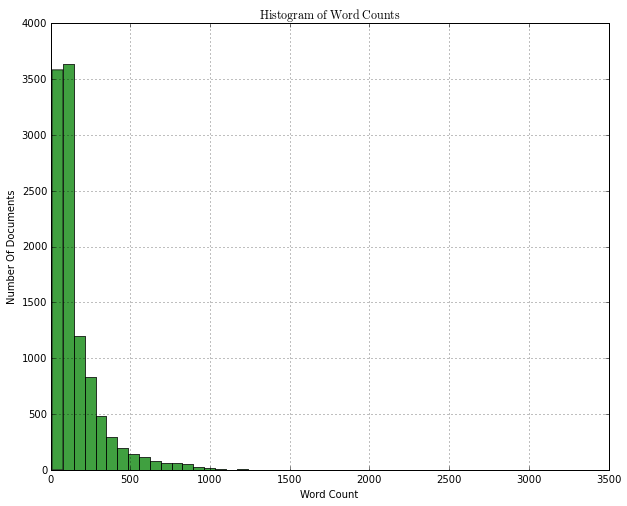

In [4]:
x = word_counts
# the histogram of the data
n, bins, patches = plt.hist(x, 50, normed=0, facecolor='green', alpha=0.75)

plt.xlabel('Word Count')
plt.ylabel('Number Of Documents')
plt.title(r'$\mathrm{Histogram\ of\ Word\ Counts}$')
# plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

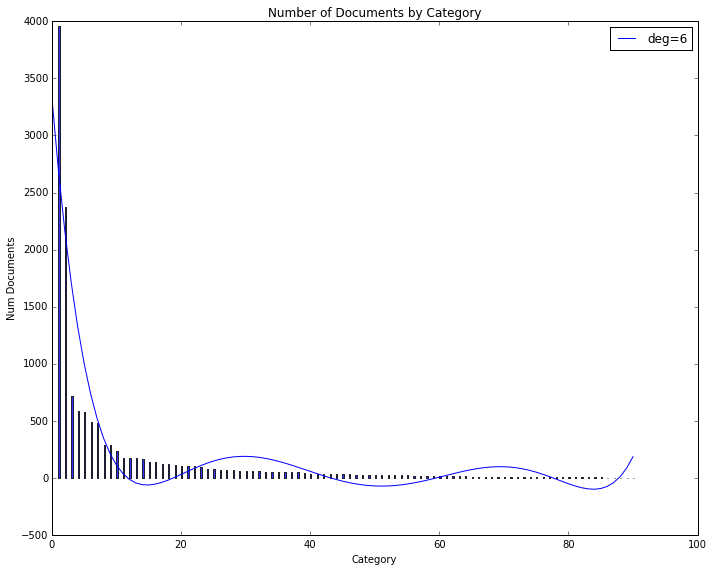

In [5]:
# histogram of categories
category_counts = Counter([category for file_id in reuters.fileids() for category in reuters.categories(file_id)])
categories, counts = zip(*category_counts.most_common())

n_groups = len(categories)

fig, ax = plt.subplots()

index = np.arange(1,n_groups+1)

bar_width = 0.2
opacity = 0.8

rects1 = plt.bar(index, counts, bar_width,
                 alpha=opacity,
                 color='b')

coeffs = np.polyfit(index, counts, 6)
x2 = np.arange(min(index)-1, max(index)+1, 1) #use more points for a smoother plot
y2 = np.polyval(coeffs, x2) #Evaluates the polynomial for each x2 value
plt.plot(x2, y2, label="deg=6")

plt.xlabel('Category')
plt.ylabel('Num Documents')
plt.title('Number of Documents by Category')
# plt.xticks(index + bar_width, ('A', 'B', 'C', 'D', 'E'))
# plt.xticks(index + bar_width, categories)
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
norm_params = pd.DataFrame([[mean_word_count, std_word_count, word_counts[0],
                             word_counts[-1], np.median(word_counts)]], 
                           columns=['mean_word_count', 'std_word_count', 'min', 'max', 'median'])
norm_params

,mean_word_count,std_word_count,min,max,median
0,159.51993,164.710894,10,3417,109


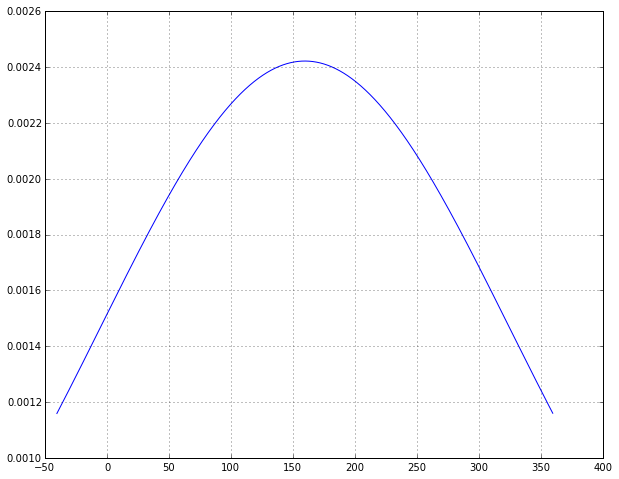

In [7]:
# let's visualize the distribution of word counts with a Gaussian
range = np.arange(mean_word_count-200, mean_word_count+200, 0.1)
plt.grid()
plt.plot(range, norm.pdf(range,mean_word_count,std_word_count))

In [8]:
# Ok, now that we know a lot about this dataset, let's clean it up a bit
# Note that our interpretation allows some instances to exist with multiple labels
# -- this is a major simplification for pedagogical purposes

max_len = 1000
min_len = 100

max_docs = 200
min_docs = 50

# limit docs to those within [min_len,max_len]
# we need to unpack the reuters corpus like this because of a bug in nltk
raw_docs = [reuters.raw(x) for x in reuters.fileids()]
raw_word_counts = [len(reuters.words(x)) for x in reuters.fileids()]
raw_categories = [reuters.categories(x) for x in reuters.fileids()]

# flatten out the list of categories (duplicate x for each category label)
dataset_instances = [(raw_docs[i],y) for i,x in enumerate(raw_docs)
                     for y in raw_categories[i]
                     if min_len <= raw_word_counts[i] <= max_len]

X, y = zip(*[(x,y) for x,y in dataset_instances])
X = np.array(X)
y = np.array(y)

# keep the docs per category within the range [min_docs, max_docs]
selected_instances = []
categories_to_keep = set([k for k,v in Counter(y).items() if v >= min_docs])

category_counter = defaultdict(int)
for i,cat in enumerate(y):
    if cat in categories_to_keep and not category_counter[cat] >= max_docs:
        selected_instances.append(i)
        category_counter[cat] += 1

X = X[selected_instances]
y = y[selected_instances]

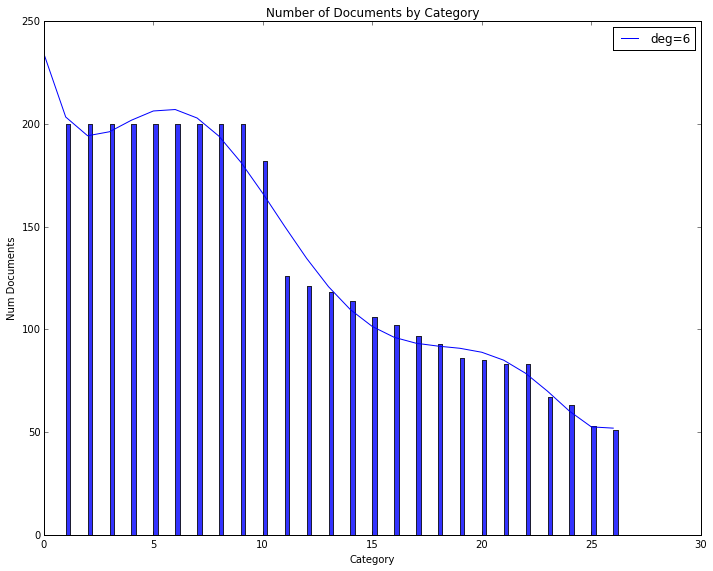

In [9]:
# visualize the categories once more
# histogram of categories
category_counts = Counter(y)
categories, counts = zip(*category_counts.most_common())

n_groups = len(categories)

fig, ax = plt.subplots()

index = np.arange(1,n_groups+1)

bar_width = 0.2
opacity = 0.8

rects1 = plt.bar(index, counts, bar_width,
                 alpha=opacity,
                 color='b')

coeffs = np.polyfit(index, counts, 6)
x2 = np.arange(min(index)-1, max(index)+1, 1)
y2 = np.polyval(coeffs, x2)
plt.plot(x2, y2, label="deg=6")

plt.xlabel('Category')
plt.ylabel('Num Documents')
plt.title('Number of Documents by Category')

plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# now we've eliminated a lot of data
len(X)

3430

In [11]:
# let's tokenize our data now, in a good format for word embeddings 
from nltk.tokenize import word_tokenize
tokenized_X = np.array([word_tokenize(x) for x in X])

In [12]:
# cool, let's save our new dataset, and get to work!
SAVE_DIR = 'datasets/reuters'
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

np.savez(os.path.join(SAVE_DIR, 'reuters_filtered'), X=X, y=y)